In [41]:
from adaptive_mesh_refiner.adaptive_meshing import AdaptiveMeshRefiner
from src.radiation_algorithm.radiation_algorithm import radiation_algorithm
from efield.efield1 import calculate_electric_magnetic_field_at_point
from efield.efield2 import radiation_intensity_distribution_over_sphere_surface
from efield.efield3 import antenna_directivity_pattern

import numpy as np
import os
import time

# fonction utiles

In [42]:
def traitement_de_(filename):
    base_name = os.path.splitext(os.path.basename(filename))[0]
    print(f"Traitement de l'antenne {base_name}")

filename_mesh1_IFA = 'data/antennas_mesh/IFA2.mat'

# Fonctions de generation de la geometrie

In [43]:
# Fonction pour générer les points de l'antenne IFA
def generate_ifa_antenna_points(L, H, ML, MH, gap, Lp):
    points = np.array([
        [0, 0], [L, 0], [L, H], [0, H], [0, H + MH], [L, H + MH], [L, H + gap], 
        [L - ML, H + gap], [L - ML, H + MH - ML], [2 * ML + Lp, H + MH - ML], 
        [2 * ML + Lp, H], [ML + Lp, H], [ML + Lp, H + MH - ML], [ML, H + MH - ML], [ML, H]
    ])
    return points

In [44]:
# Fonction pour générer les segments de l'antenne IFA   ([10, 11] feed edge)
def generate_ifa_antenna_segments():
    segments = np.array([
        [0, 1], [1, 2], [2, 10], [10, 9], [9, 8], [8, 7], [7, 6], [6, 5], [5, 4], [4, 3], 
        [0, 3], [11, 12], [12, 13], [13, 14], [11, 14], [10, 11]
    ])
    return segments

In [45]:
# Définition des dimensions de l'antenne IFA
"""L = 0.02
H = 0.05
ML = 0.001
MH = 0.015
gap = 0.0015
Lp = 0.0025
"""

L = 0.04
H = 0.035
ML = 0.004
MH = 0.015
gap = 0.0015
Lp = 0.01

# Génération des points et des segments
vertices = generate_ifa_antenna_points(L, H, ML, MH, gap, Lp)
segments = generate_ifa_antenna_segments()
# Définition des trous (un point à l'intérieur de la zone à exclure)
holes = np.array([
    [(ML + ML + Lp) / 2, (H + (H + MH - ML)) / 2]
])

In [46]:
ifa_antenna = {
    'vertices': vertices,
    'segments': segments,
    'holes': holes
}


# Parametre pour la radiation

In [47]:
feed_point_IFA = [Lp + 3 * ML / 2, H, 0]
voltage_amplitude = 1  # Valeur de l'amplitude égale à 1 volt

# Maillage Adaptatif for radiation

In [49]:
ifa_name = "IFA2"
ifa_folder = "data/antennas_mesh/"

# Création de l'objet de raffinage
mesh_ifa = AdaptiveMeshRefiner()

# Étape 1 : Génération de la triangulation initiale avec un niveau moyen
mesh_ifa.initial_meshing(ifa_antenna, ifa_name, ifa_folder, refinement_level="high")

# show_mesh(points, triangles, feed_point_IFA)  # Change "black" si besoin
mesh_ifa.show_mesh(feed_point_IFA)

Utilisation des options de triangulation : pq20a0.0001YY
Nombre de points = 20
Nombre de triangles = 25
Matrice points shape = (3, 20)
Matrice triangles shape = (4, 25)
Data saved successfully to data/antennas_mesh/IFA2.mat


In [50]:
number_of_refinement = 5  # Nombre maximum d'itérations

tolerance = 1e-2  # Seuil de variation relatif (1%)

previous_impedance = None  # Stocke l'impédance de l'itération précédente
actual_iterations = 0  # Compteur d'itérations effectives

for i in range(number_of_refinement):
    start_time = time.time()
    
    traitement_de_(filename_mesh1_IFA)
    impedance, selected_triangles = radiation_algorithm(filename_mesh1_IFA, 1.3e9, feed_point_IFA, voltage_amplitude, load_from_matlab=False)
    
    elapsed_time = time.time() - start_time
    print(f"Temps écoulé pour le traitement de l'antenne étudiée : {elapsed_time:.6f} secondes")
    print(f"Impédance actuelle : {impedance}\n")

    actual_iterations += 1
    
    # Vérifier la convergence de l'impédance
    if previous_impedance is not None:
        delta_impedance = np.abs(impedance - previous_impedance) / np.abs(previous_impedance)
        print(f"Variation relative de l'impédance : {delta_impedance:.6f}")

        if delta_impedance < tolerance:
            print("La variation de l'impédance est inférieure au seuil. Arrêt du raffinage.")
            break  # Sortir de la boucle

    previous_impedance = impedance  # Mettre à jour l'impédance précédente

    # Tentative d'affinage du maillage
    try:
        mesh_ifa.adaptative_meshing(ifa_antenna, selected_triangles, ifa_name, ifa_folder)
    except ValueError as e:
        print(f"Exception attrapée : {e}")
        break  # Arrêter si une erreur survient

# Affichage du nombre d'itérations utilisées
print(f"Nombre total d'itérations effectuées : {actual_iterations}")


Traitement de l'antenne IFA2
Total numbers of Edges is = 30
Aucune jonction complexe trouvée....
Total numbers of Edges is = 30
Data saved successfully to data/antennas_mesh1/IFA2_mesh1.mat
Data saved successfully to data/antennas_mesh2/IFA2_mesh2.mat
Temps écoulé pour le calcul de la matrice Z : 0.008935 secondes
Data saved successfully to data/antennas_impedance/IFA2_impedance.mat
Data loaded from data/antennas_mesh2/IFA2_mesh2.mat
Data loaded from data/antennas_impedance/IFA2_impedance.mat
index_feeding_edges near to the feed_point = 12
La valeur de l'impédance d'entrée de l'antenne IFA2 =  95.8683112 - 194.3432837i Ohm
Gap current of IFA2 = (0.00204148678283728+0.00413848163052086j)
Gap voltage of IFA2 = (1+0j)
La valeur de feed_power  = 0.00102074339141864
Data saved successfully to data/antennas_current/IFA2_current.mat
Sauvegarde du fichier : IFA2_current.mat effectué avec succès !
Fréquence de rayonnement de l'antenne : 1300000000.0 Hz
Max Current value = 2.7266865342927655 [A/

Temps écoulé pour le traitement de l'antenne étudiée : 0.064012 secondes
Impédance actuelle : (95.8683112481208-194.34328372089578j)

Après raffinage
Nombre de points = 40
Nombre de triangles = 65
Matrice points shape = (3, 40)
Matrice triangles shape = (4, 65)
Data saved successfully to data/antennas_mesh/IFA2.mat
Traitement de l'antenne IFA2
Total numbers of Edges is = 90
Aucune jonction complexe trouvée....
Total numbers of Edges is = 90
Data saved successfully to data/antennas_mesh1/IFA2_mesh1.mat
Data saved successfully to data/antennas_mesh2/IFA2_mesh2.mat
Temps écoulé pour le calcul de la matrice Z : 0.029156 secondes
Data saved successfully to data/antennas_impedance/IFA2_impedance.mat
Data loaded from data/antennas_mesh2/IFA2_mesh2.mat
Data loaded from data/antennas_impedance/IFA2_impedance.mat
index_feeding_edges near to the feed_point = 41
La valeur de l'impédance d'entrée de l'antenne IFA2 =  350.8610700 - 460.0391785i Ohm
Gap current of IFA2 = (0.0010481614271007419+0.0013

Temps écoulé pour le traitement de l'antenne étudiée : 0.173194 secondes
Impédance actuelle : (350.86107004358297-460.0391785464161j)

Variation relative de l'impédance : 1.699380
Après raffinage
Nombre de points = 100
Nombre de triangles = 185
Matrice points shape = (3, 100)
Matrice triangles shape = (4, 185)
Data saved successfully to data/antennas_mesh/IFA2.mat
Traitement de l'antenne IFA2
Total numbers of Edges is = 270
Aucune jonction complexe trouvée....
Total numbers of Edges is = 270
Data saved successfully to data/antennas_mesh1/IFA2_mesh1.mat
Data saved successfully to data/antennas_mesh2/IFA2_mesh2.mat
Temps écoulé pour le calcul de la matrice Z : 0.113696 secondes
Data saved successfully to data/antennas_impedance/IFA2_impedance.mat
Data loaded from data/antennas_mesh2/IFA2_mesh2.mat
Data loaded from data/antennas_impedance/IFA2_impedance.mat
index_feeding_edges near to the feed_point = 116
La valeur de l'impédance d'entrée de l'antenne IFA2 =  217.0379620 - 406.2309577i Oh

Temps écoulé pour le traitement de l'antenne étudiée : 0.965745 secondes
Impédance actuelle : (217.03796201788725-406.2309576681533j)

Variation relative de l'impédance : 0.249298
Après raffinage
Nombre de points = 283
Nombre de triangles = 551
Matrice points shape = (3, 283)
Matrice triangles shape = (4, 551)
Data saved successfully to data/antennas_mesh/IFA2.mat
Traitement de l'antenne IFA2
Total numbers of Edges is = 819
Aucune jonction complexe trouvée....
Total numbers of Edges is = 819
Data saved successfully to data/antennas_mesh1/IFA2_mesh1.mat
Data saved successfully to data/antennas_mesh2/IFA2_mesh2.mat
Temps écoulé pour le calcul de la matrice Z : 1.007304 secondes
Data saved successfully to data/antennas_impedance/IFA2_impedance.mat
Data loaded from data/antennas_mesh2/IFA2_mesh2.mat
Data loaded from data/antennas_impedance/IFA2_impedance.mat
index_feeding_edges near to the feed_point = 334
La valeur de l'impédance d'entrée de l'antenne IFA2 =  192.4886147 - 393.8863559i Oh

Temps écoulé pour le traitement de l'antenne étudiée : 6.870175 secondes
Impédance actuelle : (192.48861472569112-393.8863558653151j)

Variation relative de l'impédance : 0.059661
Après raffinage
Nombre de points = 832
Nombre de triangles = 1649
Matrice points shape = (3, 832)
Matrice triangles shape = (4, 1649)
Data saved successfully to data/antennas_mesh/IFA2.mat
Traitement de l'antenne IFA2
Total numbers of Edges is = 2466
Aucune jonction complexe trouvée....
Total numbers of Edges is = 2466
Data saved successfully to data/antennas_mesh1/IFA2_mesh1.mat
Data saved successfully to data/antennas_mesh2/IFA2_mesh2.mat
Temps écoulé pour le calcul de la matrice Z : 9.160163 secondes
Data saved successfully to data/antennas_impedance/IFA2_impedance.mat
Data loaded from data/antennas_mesh2/IFA2_mesh2.mat
Data loaded from data/antennas_impedance/IFA2_impedance.mat
index_feeding_edges near to the feed_point = 790
La valeur de l'impédance d'entrée de l'antenne IFA2 =  172.8856764 - 366.1585338

Temps écoulé pour le traitement de l'antenne étudiée : 63.771156 secondes
Impédance actuelle : (172.8856764464617-366.1585337608461j)

Variation relative de l'impédance : 0.077457
Après raffinage
Nombre de points = 2480
Nombre de triangles = 4945
Matrice points shape = (3, 2480)
Matrice triangles shape = (4, 4945)
Data saved successfully to data/antennas_mesh/IFA2.mat
Nombre total d'itérations effectuées : 5


# Plot graph

In [37]:
filename_mesh2_IFA2 = 'data/antennas_mesh2/IFA2_mesh2.mat'
filename_current_IFA2 = 'data/antennas_current/IFA2_current.mat'
filename_gain_power_IFA2 = 'data/antennas_gain_power/IFA2_gain_power.mat'
filename_sphere_dense = 'data/sphere_mesh/sphere_dense.mat'

In [38]:
# Point d'observation pour le calcul des champs
observation_point = np.array([0, 0, 10])

# Étape 1 : Calcul du champ électrique et magnétique à un point donné
print("Calculating electric and magnetic fields at observation point...")
calculate_electric_magnetic_field_at_point(filename_mesh2_IFA2, filename_current_IFA2, observation_point, radiation=True)

Calculating electric and magnetic fields at observation point...
Data loaded from data/antennas_mesh2/IFA2_mesh2.mat

Frequency = 1300000000.0 Hz
Longueur d'onde lambda = 0.23057873383123786 m
Le point d'observation est : [ 0  0 10]

e_field_total of IFA2 at the observation point [ 0  0 10] is :
 0.0000582 + 0.0000587i V/m
 0.0145978 + 0.0087322i V/m
 0.0000545 + 0.0000341i V/m

h_field_total of IFA2 at the observation point [ 0  0 10] is :
-0.0000387 - 0.0000232i A/m
 0.0000002 + 0.0000002i A/m
 0.0000000 + 0.0000000i A/m

Poynting vector is equal to : 
 0.000000 W/m^2
-0.000000 W/m^2
 0.000000 W/m^2

w = 3.839855811360171e-07 W/m^2

u = 3.839855811360171e-05 W/unit solid angle


In [39]:
# Étape 2 : Distribution de l'intensité du rayonnement sur une sphère
print("Calculating radiation intensity distribution over sphere surface...")
radiation_intensity_distribution_over_sphere_surface(filename_mesh2_IFA2, filename_current_IFA2, filename_sphere_dense, radiation=True)

Calculating radiation intensity distribution over sphere surface...
Data loaded from data/antennas_mesh2/IFA2_mesh2.mat

Frequency = 1300000000.0 Hz
Longueur d'onde lambda = 0.23057873383123786 m

Total Power :  0.000323
Gain Linear :  1.531597
Gain Logarithmic :  1.851445 dB
Radiation Resistance :  62.122574 Ohms
Data saved successfully to data/antennas_gain_power/IFA2_gain_power.mat


Generating antenna directivity pattern...
Data loaded from data/antennas_mesh2/IFA2_mesh2.mat
Data loaded from data/antennas_gain_power/IFA2_gain_power.mat


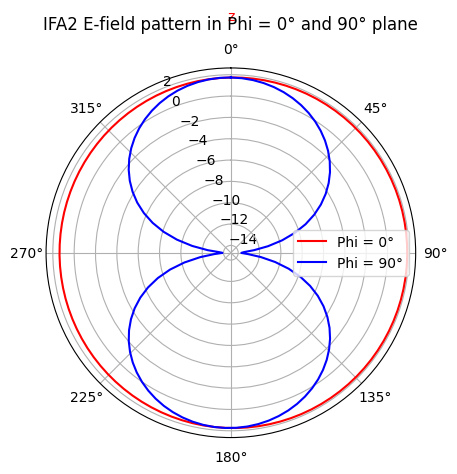

In [40]:
# Étape 3 : Génération du diagramme de directivité
print("Generating antenna directivity pattern...")
antenna_directivity_pattern(filename_mesh2_IFA2, filename_current_IFA2, filename_gain_power_IFA2, radiation=True)